<a href="https://colab.research.google.com/github/Nik02hari/Depolymerase-prediction-using-DepoScope/blob/main/m6_seq33.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install biopython
!pip3 install phanotate
!wget 'https://zenodo.org/records/10957073/files/esm2_t12_finetuned_depolymerases.zip?download=1' -O 'esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4.zip'
!wget 'https://zenodo.org/records/10957073/files/Deposcope.esm2_t12_35M_UR50D.2203.full.model?download=1' -O 'DepoDetection.model'
!unzip /content/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4.zip -d /content/DepoScope_finetuned
!rm -r /content/DepoScope_finetuned/__MACOSX
!unzip /content/phage_genomes.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastpath: filename=fastpath-1.9-cp311-cp311-linux_x86_64.whl size=167008 sha256=9d87e339281084d996e0a053e4238d24b5b7698461efea044a15a04af669b083
  Stored in directory: /root/.cache/pip/wheels/cd/99/2e/5e297f3e43f5b3fce8b850fff745b04fb17083026c4429a79d
Successfully built fastpath
--2025-04-14 09:28:21--  https://zenodo.org/records/10957073/files/esm2_t12_finetuned_depolymerases.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372353856 (355M) [application/octet-stream]
Saving to: ‘esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4.zip’

esm2_t12_35M_UR50D- 100%[===================>] 355.10M   828

In [ ]:
import os
import torch
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from Bio import SeqIO
from Bio.Seq import Seq
from tqdm.notebook import tqdm
from transformers import AutoModelForTokenClassification, AutoTokenizer

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
path = '/content/m6.fasta'
data_suf = ''
phanotate_path = 'phanotate.py'

In [ ]:
def phanotate_processing(path, phanotate_path='phanotate', data_suffix=''):
    """
    Runs PHANOTATE on a single genome file and extracts genes.

    INPUTS:
    - path: full path to the input fasta file (e.g., '/content/m6.fasta')
    - phanotate_path: PHANOTATE command (default='phanotate')
    - data_suffix: optional suffix for output CSV

    OUTPUT:
    - phage_genes<suffix>.csv file saved to the same directory as input
    """
    file = os.path.basename(path)
    name = file.split('.fasta')[0]
    count = 1
    name_list = []; gene_list = []; gene_ids = []

    # Run PHANOTATE on the fasta file
    raw_str = f"{phanotate_path} {path}"
    process = subprocess.Popen(raw_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, _ = process.communicate()

    std_splits = stdout.split(sep=b'\n')[2:]  # Skip headers
    tsv_path = '/content/phage_results.tsv'
    with open(tsv_path, 'wb') as temp_tab:
        for split in std_splits:
            split = split.replace(b',', b'')  # Clean up commas
            temp_tab.write(split + b'\n')

    results_orfs = pd.read_csv(tsv_path, sep='\t', lineterminator='\n', index_col=False)
    os.remove(tsv_path)

    # Parse sequences
    sequence = str(SeqIO.read(path, 'fasta').seq)
    for j, strand in enumerate(results_orfs['FRAME']):
        start = results_orfs['#START'][j]
        stop = results_orfs['STOP'][j]

        if strand == '+':
            gene = sequence[start-1:stop]
        else:
            sequence_part = sequence[stop-1:start]
            gene = str(Seq(sequence_part).reverse_complement())

        name_list.append(name)
        gene_list.append(gene)
        gene_ids.append(f"{name}_gp{count}")
        count += 1

    # Save results
    genebase = pd.DataFrame(list(zip(name_list, gene_ids, gene_list)), columns=['phage_ID', 'gene_ID', 'gene_sequence'])
    output_csv = f"/content/phage_genes{data_suffix}.csv"
    genebase.to_csv(output_csv, index=False)
    print(f"[INFO] Gene predictions saved to: {output_csv}")


In [ ]:
def phanotate_processing(fasta_path, phanotate_path, data_suffix=''):
    """
    Runs PHANOTATE on a single phage genome FASTA file and saves predicted gene sequences.

    Parameters:
    - fasta_path: path to the input phage genome FASTA file (e.g., '/content/m6.fasta')
    - phanotate_path: path to the PHANOTATE executable (e.g., 'phanotate' or full path)
    - data_suffix: optional suffix for the output CSV file name

    Output:
    - CSV file with columns: phage_ID, gene_ID, gene_sequence
    """
    phage_name = os.path.basename(fasta_path).replace('.fasta', '')
    output_tsv = '/content/phage_results.tsv'

    # Run PHANOTATE
    command = f"{phanotate_path} {fasta_path}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = process.communicate()

    # Parse PHANOTATE output
    lines = stdout.splitlines()[2:]  # skip header
    with open(output_tsv, 'wb') as f:
        for line in lines:
            f.write(line.replace(b',', b'') + b'\n')

    df = pd.read_csv(output_tsv, sep='\t', lineterminator='\n', index_col=False)
    os.remove(output_tsv)

    # Extract sequences
    name_list = []
    gene_list = []
    gene_ids = []
    sequence = str(SeqIO.read(fasta_path, 'fasta').seq)
    count = 1

    for j, strand in enumerate(df['FRAME']):
        start = df['#START'][j]
        stop = df['STOP'][j]

        if strand == '+':
            gene_seq = sequence[start-1:stop]
        else:
            gene_seq = str(Seq(sequence[stop-1:start]).reverse_complement())

        name_list.append(phage_name)
        gene_list.append(gene_seq)
        gene_ids.append(f"{phage_name}_gp{count}")
        count += 1

    result_df = pd.DataFrame({
        'phage_ID': name_list,
        'gene_ID': gene_ids,
        'gene_sequence': gene_list
    })

    out_csv = f"/content/phage_genes{data_suffix}.csv"
    result_df.to_csv(out_csv, index=False)
    print(f"[INFO] Gene predictions saved to: {out_csv}")


In [ ]:
path = '/content/m6.fasta'
data_suf = ''
phanotate_path = 'phanotate'  # or use '/usr/local/bin/phanotate.py' if needed


In [ ]:
phanotate_processing(path, phanotate_path, data_suffix=data_suf)


EmptyDataError: No columns to parse from file

In [ ]:
import subprocess

result = subprocess.run([phanotate_path, path], capture_output=True, text=True)
print(result.stdout)
print(result.stderr)


FileNotFoundError: [Errno 2] No such file or directory: 'phanotate'

In [ ]:
!which phanotate.py



/usr/local/bin/phanotate.py


In [ ]:
import os
import subprocess
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq

def phanotate_processing(path, phanotate_path='/usr/local/bin/phanotate.py', data_suffix=''):
    """
    Runs PHANOTATE on a single genome file and extracts genes.

    INPUTS:
    - path: full path to the input fasta file (e.g., '/content/m6.fasta')
    - phanotate_path: full path to PHANOTATE script (default='/usr/local/bin/phanotate.py')
    - data_suffix: optional suffix for output CSV

    OUTPUT:
    - phage_genes<suffix>.csv file saved to the same directory as input
    """
    file = os.path.basename(path)
    name = file.split('.fasta')[0]
    count = 1
    name_list = []; gene_list = []; gene_ids = []

    # Run PHANOTATE on the fasta file
    raw_str = f"python {phanotate_path} {path}"
    process = subprocess.Popen(raw_str, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, _ = process.communicate()

    std_splits = stdout.split(sep=b'\n')[2:]  # Skip headers
    tsv_path = '/content/phage_results.tsv'
    with open(tsv_path, 'wb') as temp_tab:
        for split in std_splits:
            if split.strip():  # Only write non-empty lines
                split = split.replace(b',', b'')  # Clean up commas
                temp_tab.write(split + b'\n')

    if os.path.getsize(tsv_path) == 0:
        raise RuntimeError("[ERROR] PHANOTATE output was empty. Please check the input file or phanotate script.")

    results_orfs = pd.read_csv(tsv_path, sep='\t', lineterminator='\n', index_col=False)
    os.remove(tsv_path)

    # Parse sequences
    sequence = str(SeqIO.read(path, 'fasta').seq)
    for j, strand in enumerate(results_orfs['FRAME']):
        start = results_orfs['#START'][j]
        stop = results_orfs['STOP'][j]

        if strand == '+':
            gene = sequence[start-1:stop]
        else:
            sequence_part = sequence[stop-1:start]
            gene = str(Seq(sequence_part).reverse_complement())

        name_list.append(name)
        gene_list.append(gene)
        gene_ids.append(f"{name}_gp{count}")
        count += 1

    # Save results
    genebase = pd.DataFrame(list(zip(name_list, gene_ids, gene_list)), columns=['phage_ID', 'gene_ID', 'gene_sequence'])
    output_csv = f"/content/phage_genes{data_suffix}.csv"
    genebase.to_csv(output_csv, index=False)
    print(f"[INFO] Gene predictions saved to: {output_csv}")


In [ ]:
path = '/content/m6.fasta'
data_suf = ''
phanotate_path = '/usr/local/bin/phanotate.py'

phanotate_processing(path, phanotate_path, data_suffix=data_suf)


[INFO] Gene predictions saved to: /content/phage_genes.csv


In [ ]:
from Bio.Seq import Seq
import pandas as pd

# Define the correct path
csv_path = '/content/phage_genes.csv'

# Load the predicted gene sequences
phage_genes = pd.read_csv(csv_path)

# Translate to protein sequences (removing stop codon '*')
proteins = [str(Seq(gene).translate())[:-1] for gene in phage_genes['gene_sequence']]

# Add to DataFrame
phage_genes['protein_sequence'] = proteins

# Save the updated CSV
phage_genes.to_csv(csv_path, index=False)

print("[INFO] Protein sequences added and file updated at:", csv_path)


[INFO] Protein sequences added and file updated at: /content/phage_genes.csv


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Set the base path
base_path = '/content'

# Correct model paths
esm2_model_path = base_path + '/DepoScope_finetuned/esm2_t12_35M_UR50D__fulltrain__finetuneddepolymerase.2103.4_labels/checkpoint-2255'
DpoDetection_path = base_path + '/DepoDetection.model'

# Load the tokenizer and fine-tuned model
tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)

print("[INFO] Model and tokenizer loaded successfully.")


[INFO] Model and tokenizer loaded successfully.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Define the classifier class
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # First convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Second convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # Flattened size after conv layers
        self.classifier = nn.Linear(32, 1)  # Final classification layer

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)
            tokens = token_ids.view(1, -1)  # Ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)

        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # Ensure 3D shape
        outputs = outputs.float()  # Convert to float

        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to predict a single sequence using the model
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Sigmoid for binary classification
        predictions = (probas > 0.5).float()  # Threshold at 0.5
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list

# Function to visualize token predictions
def plot_tokens(tokens):
    tokens = np.array(tokens)  # Convert list to numpy array
    plt.figure(figsize=(10, 6))
    token_dict = {0: 'negative', 1: 'beta_helix', 2: 'beta_propeller', 3: 'triple_helix'}
    color_dict = {0: 'black', 1: 'green', 2: 'blue', 3: 'red'}

    for i in range(len(tokens) - 1):
        plt.plot([i, i+1], [tokens[i], tokens[i+1]],
                 color=color_dict.get(tokens[i], 'gray'),
                 marker='o',
                 label=token_dict.get(tokens[i], 'unknown'))

    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.yticks(np.arange(4), ['0', '1', '2', '3'])

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Token Classification Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Instantiate the model with the finetuned ESM2
model_classifier = Dpo_classifier(esm2_finetuned)

# Load the saved model weights
model_classifier.load_state_dict(torch.load(DpoDetection_path, map_location=torch.device('cpu')), strict=False)

# Set model to evaluation mode
model_classifier.eval()

print("[INFO] Model classifier instantiated and weights loaded successfully.")


[INFO] Model classifier instantiated and weights loaded successfully.


In [ ]:
# Instantiate the Dpo_classifier model with the finetuned ESM2
model_classifier = Dpo_classifier(esm2_finetuned)

# Load the model weights from the saved file
model_classifier.load_state_dict(torch.load(DpoDetection_path, map_location=torch.device('cpu')), strict=False)

# Set the model to evaluation mode for inference
model_classifier.eval()

print("[INFO] Model instantiated and weights loaded successfully.")


[INFO] Model instantiated and weights loaded successfully.


In [ ]:
# Load the phage gene data
phage_genes = pd.read_csv(path+'/phage_genes'+data_suf+'.csv')

# Initialize lists to store the results
scores_DepoScope = []
token_scores_DepoScope = []

# Loop through each protein sequence in the dataframe and run predictions
for protein_seq in tqdm(phage_genes['protein_sequence']):
    # Make a prediction for the current protein sequence
    prediction, sequence_outputs = predict_sequence(model_classifier, protein_seq)

    # Store the predicted score and token-level outputs
    scores_DepoScope.append(prediction[1])
    token_scores_DepoScope.append(sequence_outputs)

# Optionally, save the prediction results into a DataFrame
phage_genes['DepoScope_score'] = scores_DepoScope
phage_genes['token_scores'] = token_scores_DepoScope

# Save the updated DataFrame
phage_genes.to_csv(path+'/phage_genes_with_predictions'+data_suf+'.csv', index=False)

print("[INFO] Predictions complete and results saved to: phage_genes_with_predictions.csv")


NotADirectoryError: [Errno 20] Not a directory: '/content/m6.fasta/phage_genes.csv'

In [ ]:
# Set the correct directory path for the CSV file (you should set this to the directory containing the file)
directory_path = '/content/'  # Or the appropriate directory path

# Load the phage gene data from the correct path
phage_genes = pd.read_csv(directory_path+'phage_genes'+data_suf+'.csv')

# Initialize lists to store the results
scores_DepoScope = []
token_scores_DepoScope = []

# Loop through each protein sequence in the dataframe and run predictions
for protein_seq in tqdm(phage_genes['protein_sequence']):
    # Make a prediction for the current protein sequence
    prediction, sequence_outputs = predict_sequence(model_classifier, protein_seq)

    # Store the predicted score and token-level outputs
    scores_DepoScope.append(prediction[1])
    token_scores_DepoScope.append(sequence_outputs)

# Optionally, save the prediction results into a DataFrame
phage_genes['DepoScope_score'] = scores_DepoScope
phage_genes['token_scores'] = token_scores_DepoScope

# Save the updated DataFrame to a new CSV file
phage_genes.to_csv(directory_path+'phage_genes_with_predictions'+data_suf+'.csv', index=False)

print("[INFO] Predictions complete and results saved to: phage_genes_with_predictions.csv")


  0%|          | 0/88 [00:00<?, ?it/s]

[INFO] Predictions complete and results saved to: phage_genes_with_predictions.csv


In [ ]:
# Concatenate the predictions into the DataFrame
phage_genes = pd.concat([phage_genes, pd.DataFrame({'scores_DepoScope': scores_DepoScope})], axis=1)

# Save the updated DataFrame with predictions to the correct directory
phage_genes.to_csv(directory_path+'phage_genes_with_predictions'+data_suf+'.csv', index=False)

print("[INFO] Predictions saved to: phage_genes_with_predictions.csv")


[INFO] Predictions saved to: phage_genes_with_predictions.csv


In [ ]:
# Load the CSV file with the predictions
phage_genes = pd.read_csv(path+'/phage_genes_with_predictions'+data_suf+'.csv')

# Display the contents to verify the predictions
print(phage_genes.head())  # Display the first few rows to verify the predictions


NotADirectoryError: [Errno 20] Not a directory: '/content/m6.fasta/phage_genes_with_predictions.csv'

In [ ]:
import os
print(os.path.isfile(path+'/phage_genes_with_predictions'+data_suf+'.csv'))


False


In [ ]:
import os
print(os.listdir('/content/'))


['.config', 'esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4.zip', 'phage_genes_with_predictions.csv', 'DepoDetection.model', 'm6.fasta', 'phage_genes.csv', 'DepoScope_finetuned', 'sample_data']


In [ ]:
phage_genes = pd.read_csv('/content/phage_genes_with_predictions.csv')
print(phage_genes.head())  # Check the first few rows


  phage_ID gene_ID                                      gene_sequence  \
0       m6  m6_gp1  GCCCAGGAGGTCGCCCGCCGGGTCCCGCACCTCGCCCTGCCGAAGC...   
1       m6  m6_gp2  ATGAGCAAGATCACAGCCACCCGCATCGACAACGATGACCAGCGCC...   
2       m6  m6_gp3  ATGACCAAATCCGCCCCCAAGACCAACCTCCTGGAGGAGACCATCA...   
3       m6  m6_gp4  ATGGCCAACATGAGCTACTGCCGTTGGGAGAACACCCTCAACGACC...   
4       m6  m6_gp5  ATGAGCGGACGCTACAAGGTCCTGGTCGGGTCCCAATCCGGCCACT...   

                                    protein_sequence  DepoScope_score  \
0  AQEVARRVPHLALPKPKPDLYVGEPKKRMTFDVTVVRRYTFARDAW...         0.000327   
1  MSKITATRIDNDDQRLQVLPAHFGADFLRVEMALYDHLQKMAPEDY...         0.000327   
2  MTKSAPKTNLLEETINEGRQDVTARRVLSLGDFKVRLTIKSDSYKF...         0.000327   
3  MANMSYCRWENTLNDLRDCAEHVNDPLGGSEARARASLLELAADML...         0.000327   
4  MSGRYKVLVGSQSGHCCFDYTVVDTLKPHPVYASQGLFDAICETFS...         0.000327   

                                        token_scores  scores_DepoScope  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

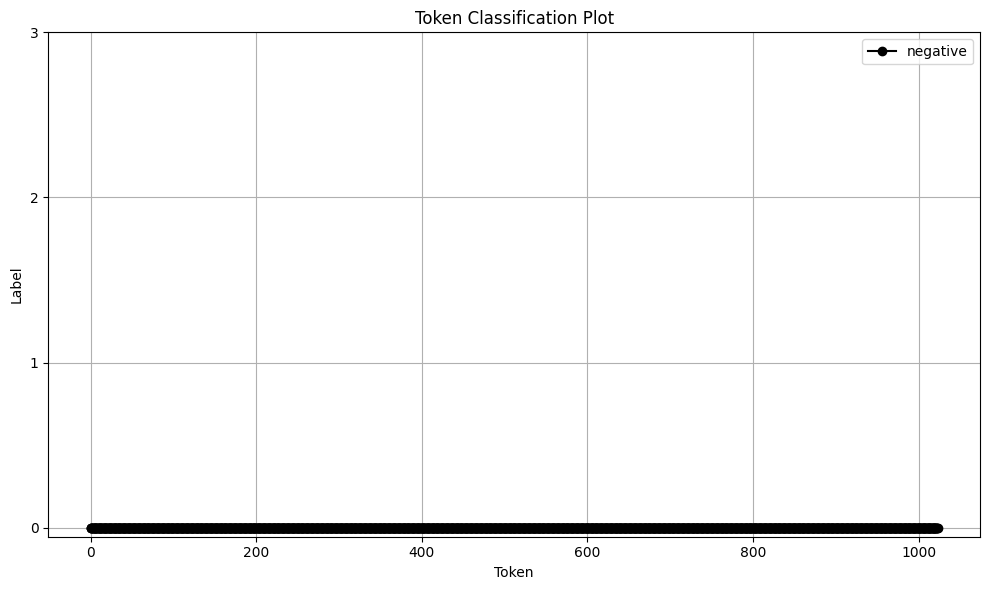

In [ ]:
# Assuming 'token_scores_DepoScope' contains the token scores for each sequence
# Visualize the token predictions for the first gene (index 0)
plot_tokens(token_scores_DepoScope[0])


In [ ]:
from collections import Counter
all_labels = [label for seq in token_scores_DepoScope for label in seq]
print(Counter(all_labels))


Counter({0.0: 90003, 2.0: 109})


In [ ]:
for idx, token_seq in enumerate(token_scores_DepoScope):
    if 2 in token_seq:
        print(f"Sequence {idx} has beta_propeller prediction.")


Sequence 33 has beta_propeller prediction.


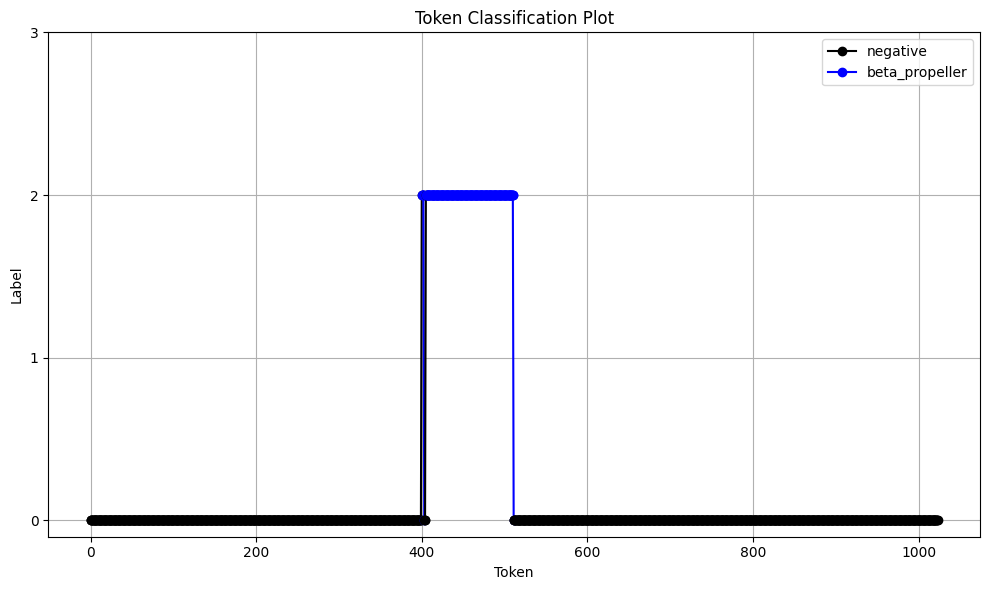

In [ ]:
plot_tokens(token_scores_DepoScope[33])


In [ ]:
print(phage_genes.iloc[33][['protein_sequence', 'scores_DepoScope']])


protein_sequence    MANEIGTATNFEDFFSKIIAFLTTNAALVSAGQAWQALRVRRDNID...
scores_DepoScope                                             0.999701
Name: 33, dtype: object


In [ ]:
def get_beta_propeller_region(seq, token_labels):
    start = token_labels.index(2)
    end = len(token_labels) - token_labels[::-1].index(2)
    return seq[start:end]

aa_region = get_beta_propeller_region(phage_genes.iloc[33]['protein_sequence'], token_scores_DepoScope[33])
print(aa_region)


GPTVSSSPPYNVGINNAGLRNVWPHCMNGQWSWGLRPYRECLGGGYILQPCVLIQRSPAQVLGELEGTFAISGYQNSAENTTVFNGKTHVVFQNAYRNTIHEHWALSMD
